In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train

c:\Users\bhish\OneDrive\Desktop\V Semester\Deep Learning\Projects\Mnist\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  2.30 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.91 url/s]


Dataset mnist downloaded and prepared to C:\Users\bhish\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\bhish\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [8]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)


def invert(image, label):
    return (tf.cast(image, tf.float32) * -1.0) + 1.0, label


inverted = ds_train.map(invert)
ds_train = ds_train.concatenate(inverted)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples*2)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
ds_test = ds_test.map(normalize_img)

inverted = ds_test.map(invert)
ds_test = ds_test.concatenate(inverted)

ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
max_pool = tf.keras.layers.MaxPool2D((2, 2), (2, 2), padding='same')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=5,
        padding="same",
        activation=tf.nn.relu),
    max_pool,
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        padding="same",
        activation=tf.nn.relu),
    max_pool,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

In [11]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8072 - loss: 0.5983 - val_accuracy: 0.9833 - val_loss: 0.0532
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9750 - loss: 0.0824 - val_accuracy: 0.9886 - val_loss: 0.0354
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9812 - loss: 0.0606 - val_accuracy: 0.9881 - val_loss: 0.0355
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9856 - loss: 0.0477 - val_accuracy: 0.9906 - val_loss: 0.0284
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9872 - loss: 0.0391 - val_accuracy: 0.9913 - val_loss: 0.0284
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9898 - loss: 0.0325 - val_accuracy: 0.9926 - val_loss: 0.0232
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9910 - loss: 0.0292 - val_accuracy: 0.9916 - val_loss: 0.0255
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9916 - loss: 0.0267 - 

In [12]:
import numpy as np
from skimage.io import imread

images = []
for i in list(range(1,10)) + ["dog"]:
    images.append(np.array(imread(f"test/{i}.png")/255.0, dtype='float32'))
images = np.array(images)[:,:,:,np.newaxis]
test_data = tf.convert_to_tensor(images)

In [22]:
import matplotlib.pyplot as plt

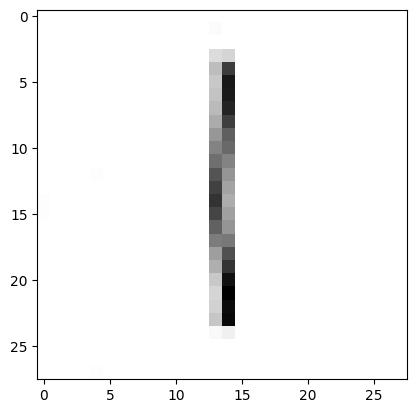

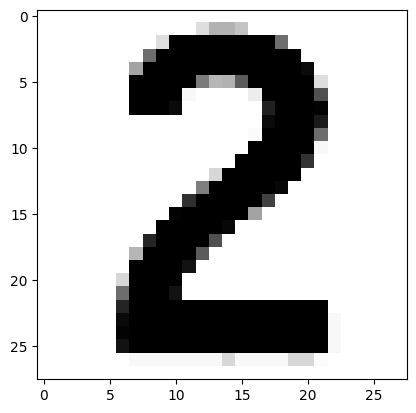

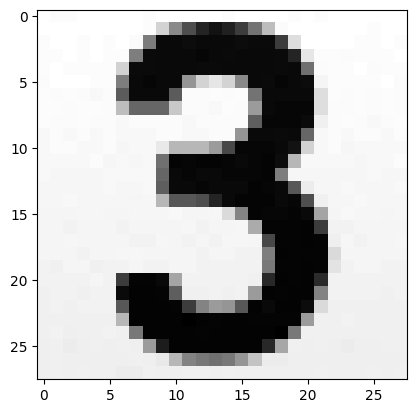

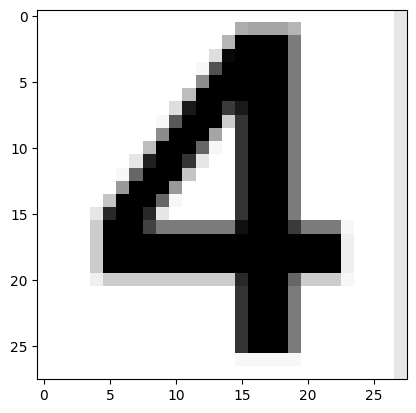

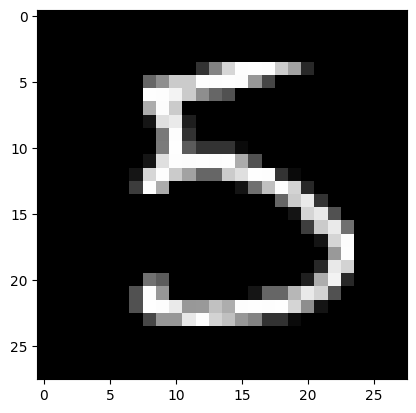

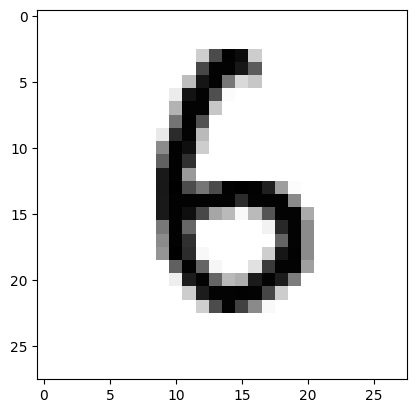

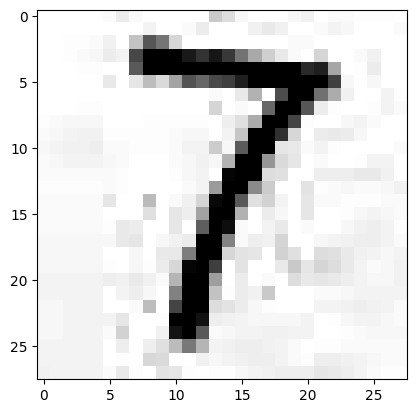

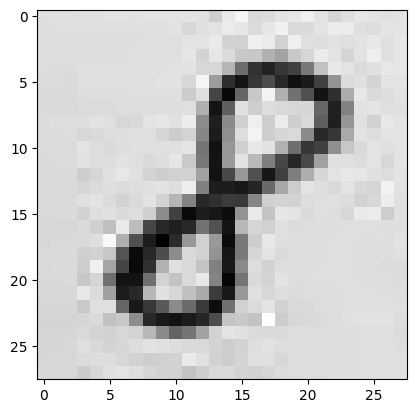

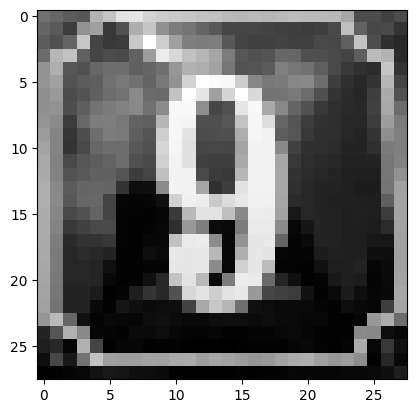

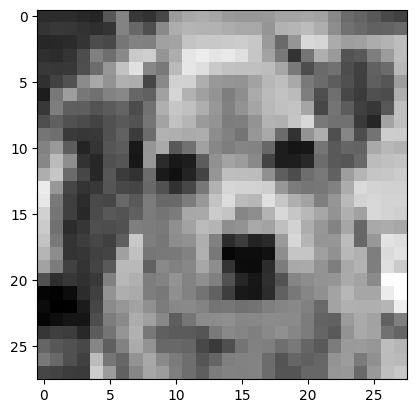

In [26]:
for img in test_data:
    plt.imshow(img, cmap='gray')
    plt.show()

In [19]:
predictions = model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [20]:
truths = list(range(1, 10)) + ["dog"]

table = []
for truth, probs in zip(truths, predictions):
    prediction = probs.argmax()
    if truth == 'dog':
        print(f"{truth}. CNN thinks it's a {prediction} ({probs[prediction]*100:.1f}%)")
    else:
        print(f"{truth} at {probs[truth]*100:4.1f}%. CNN thinks it's a {prediction} ({probs[prediction]*100:4.1f}%)")
    table.append((truth, probs))

1 at 55.5%. CNN thinks it's a 1 (55.5%)
2 at 100.0%. CNN thinks it's a 2 (100.0%)
3 at 100.0%. CNN thinks it's a 3 (100.0%)
4 at 100.0%. CNN thinks it's a 4 (100.0%)
5 at 100.0%. CNN thinks it's a 5 (100.0%)
6 at 100.0%. CNN thinks it's a 6 (100.0%)
7 at 99.9%. CNN thinks it's a 7 (99.9%)
8 at 100.0%. CNN thinks it's a 8 (100.0%)
9 at  2.5%. CNN thinks it's a 8 (93.2%)
dog. CNN thinks it's a 8 (49.6%)


In [31]:
def print_table(table):
    print("""<table cellpadding="0" style="border-collapse: collapse; border-style: hidden;">
    <thead>
    <tr>
    <td><b>Image</b></td>
    <td><b>0</b></td>
    <td><b>1</b></td>
    <td><b>2</b></td>
    <td><b>3</b></td>
    <td><b>4</b></td>
    <td><b>5</b></td>
    <td><b>6</b></td>
    <td><b>7</b></td>
    <td><b>8</b></td>
    <td><b>9</b></td>
    </tr>
    </thead>
    <tbody>""")
    for truth, l in table:
        print("<tr>")
        print(f'<td><img src="test/{truth}.png" style="margin: 1px 0px"></td>')
        highest_prob = l.argmax()
        for j, m in enumerate(l):
            if j == highest_prob:
                if highest_prob == truth:
                    colour = "green"
                else:
                    colour = "red"
                print(f'<td style="color:{colour};">{int(round(m*100))}%</td>')
            else:
                print(f"<td>{int(round(m*100))}%</td>")
        print("</tr>")
    print("""</tbody>
    </table>""")

print_table(table)

<table cellpadding="0" style="border-collapse: collapse; border-style: hidden;">
    <thead>
    <tr>
    <td><b>Image</b></td>
    <td><b>0</b></td>
    <td><b>1</b></td>
    <td><b>2</b></td>
    <td><b>3</b></td>
    <td><b>4</b></td>
    <td><b>5</b></td>
    <td><b>6</b></td>
    <td><b>7</b></td>
    <td><b>8</b></td>
    <td><b>9</b></td>
    </tr>
    </thead>
    <tbody>
<tr>
<td><img src="test/1.png" style="margin: 1px 0px"></td>
<td>10%</td>
<td style="color:green;">55%</td>
<td>1%</td>
<td>3%</td>
<td>0%</td>
<td>2%</td>
<td>0%</td>
<td>19%</td>
<td>1%</td>
<td>8%</td>
</tr>
<tr>
<td><img src="test/2.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/3.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>

<table cellpadding="0" style="border-collapse: collapse; border-style: hidden;">
    <thead>
    <tr>
    <td><b>Image</b></td>
    <td><b>0</b></td>
    <td><b>1</b></td>
    <td><b>2</b></td>
    <td><b>3</b></td>
    <td><b>4</b></td>
    <td><b>5</b></td>
    <td><b>6</b></td>
    <td><b>7</b></td>
    <td><b>8</b></td>
    <td><b>9</b></td>
    </tr>
    </thead>
    <tbody>
<tr>
<td><img src="test/1.png" style="margin: 1px 0px"></td>
<td>10%</td>
<td style="color:green;">55%</td>
<td>1%</td>
<td>3%</td>
<td>0%</td>
<td>2%</td>
<td>0%</td>
<td>19%</td>
<td>1%</td>
<td>8%</td>
</tr>
<tr>
<td><img src="test/2.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/3.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/4.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/5.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/6.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/7.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/8.png" style="margin: 1px 0px"></td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:green;">100%</td>
<td>0%</td>
</tr>
<tr>
<td><img src="test/9.png" style="margin: 1px 0px"></td>
<td>3%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td>1%</td>
<td>0%</td>
<td>0%</td>
<td>0%</td>
<td style="color:red;">93%</td>
<td>3%</td>
</tr>
<tr>
<td><img src="test/dog.png" style="margin: 1px 0px"></td>
<td>7%</td>
<td>1%</td>
<td>2%</td>
<td>5%</td>
<td>0%</td>
<td>13%</td>
<td>21%</td>
<td>1%</td>
<td style="color:red;">50%</td>
<td>0%</td>
</tr>
</tbody>
    </table>
